# Bennets Hipathia Script

## 1. Instalation & Setup

In [1]:
# --- Install 'dplyr' if missing ---
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}

# --- Install BiocManager if missing ---
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}

# --- Install or update 'hipathia' from Bioconductor ---
BiocManager::install("hipathia", ask = FALSE, update = TRUE)

# --- Load core libraries ---
library(dplyr)
library(hipathia)

# --- Check installed versions (optional but useful for documentation) ---
packageVersion("hipathia")
packageVersion("dplyr")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.20 (BiocManager 1.30.26), R 4.4.3 (2025-02-28)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'hipathia'”
Old packages: 'Biostrings', 'digest', 'gower', 'IRanges', 'mgcv', 'purrr',
  'rbibutils', 'reshape2', 'RSQLite', 'SparseArray'

Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘digest’ had non-zero exit status”
Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘gower’ had non-zero exit status”
Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘IRanges’ had non-zero ex

[1] ‘3.6.0’

[1] ‘1.1.4’

## 2. PARAMETERS

### 2.1 Set Paramter 

In [3]:
# ---- Input files ----
rna_path  <- "rna_data_filtered wtumor.csv"        # raw RNA matrix: Genes × Cells
meta_path <- "complet_cell_metadata_grouped.csv"   # metadata with cell_id + celltype info

# ---- Output files ----
rna_standardized_out <- "rna_standardized.csv"
expr_pseudobulk_out  <- "expr_pseudobulk_symbols.csv"
design_out           <- "design.csv"

# Column in metadata that contains celltype annotation
group_column <- "celltype"
# ---- DEFINE GROUPS YOU WANT TO COMPARE ----
group1_name  <- "Normal"        # name in output (left in Hipathia)
group2_name  <- "Tumor"        # name in output (right in Hipathia)
# Which celltypes belong to each group?
group1_types <- c("Mesothelium")     # OR: c("CD4 T_cells")
group2_types <- c("Malignant")       # OR: c("CD8 T_cells")

# 2.3 Sample ID to inspect for celltype composition
inspect_sample <- "p848"

# Combined list of valid groups
allowed_groups <- c(group1_types, group2_types)

# ---- Options ----
pseudobulk_method <- "sum"
min_overlap_prop  <- 0.9
min_cells     <- 30

# ---- Hipathia ----
species       <- "hsa"
pathways_list <- c()   # empty = load all pathways





## PATIENT FILTERING

In [4]:
# Load metadata
meta <- read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE)

# Ensure required columns exist
stopifnot(all(c("cell_id", "orig.ident", group_column) %in% colnames(meta)))

# Merge pXXXpos / pXXXneg → pXXX (patient-level)
meta$patient_id <- gsub("pos|neg", "", meta$orig.ident)

# Filter metadata to keep only the groups defined in the parameter block
meta_filt <- meta[meta[[group_column]] %in% c(group1_types, group2_types), ]

# Count cells per patient × group
cell_counts <- table(meta_filt$patient_id, meta_filt[[group_column]])

# Universal: sum counts for each group1/group2 type (in case multiple celltypes belong to a group)
group1_counts <- rowSums(cell_counts[, group1_types, drop = FALSE])
group2_counts <- rowSums(cell_counts[, group2_types, drop = FALSE])

# Which patients have enough cells from BOTH groups?
valid_patients <- names(which(group1_counts >= min_cells & group2_counts >= min_cells))


# ============================================
# BUILD GROUPED PATIENT × CELLTYPE TABLE
# ============================================

patients <- rownames(cell_counts)

# Reihen in der richtigen Reihenfolge
rows <- c(
  paste0('group1_name = "', group1_name, '"'),
  group1_types,
  paste0('group2_name = "', group2_name, '"'),
  group2_types,
  "keep"
)

# Matrix erstellen
diagnosis_matrix <- matrix(
  "",
  nrow = length(rows),
  ncol = length(patients),
  dimnames = list(rows, patients)
)

# Summen für group1
for (p in patients) {
  diagnosis_matrix[paste0('group1_name = "', group1_name, '"'), p] <-
    sum(cell_counts[p, group1_types], na.rm = TRUE)
}

# Summen für group2
for (p in patients) {
  diagnosis_matrix[paste0('group2_name = "', group2_name, '"'), p] <-
    sum(cell_counts[p, group2_types], na.rm = TRUE)
}

# Einzelne Celltypes einfügen
for (ct in group1_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[, ct])
}
for (ct in group2_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[, ct])
}

# keep-Zeile
diagnosis_matrix["keep", ] <- ifelse(
  group1_counts >= min_cells & group2_counts >= min_cells,
  "TRUE",
  "FALSE"
)


# In data.frame konvertieren
diagnosis_table <- as.data.frame(diagnosis_matrix)


# Print diagnostic table
print(diagnosis_table)

cat("\n===== PATIENT FILTERING DONE =====\n")
cat("Comparison: ", group1_name, " vs ", group2_name, "\n", sep = "")
cat("Min cells per group required: ", min_cells, "\n", sep = "")
cat("Patients passing filter: ", paste(valid_patients, collapse = ", "), "\n\n", sep = "")

# Final metadata restricted to valid patients only
meta_final <- meta_filt[meta_filt$patient_id %in% valid_patients, ]

# After filtering patients: extract valid cell barcodes
filtered_barcodes <- unique(meta_final$cell_id)

if (length(filtered_barcodes) == 0) {
    stop("Patient filter produced zero remaining cell barcodes.")
}

message("Number of remaining barcodes after filtering: ", length(filtered_barcodes))



                         p11   p12  p13   p4    p7 p786    p8  p811  p826  p846
group1_name = "Normal"     0     0   32   58     0  286     0     0     0     0
Mesothelium                0     0   32   58     0  286     0     0     0     0
group2_name = "Tumor"   1021  1143  116  330  2280  174  5672 11618  4109    97
Malignant               1021  1143  116  330  2280  174  5672 11618  4109    97
keep                   FALSE FALSE TRUE TRUE FALSE TRUE FALSE FALSE FALSE FALSE
                        p848    p9
group1_name = "Normal"     0     0
Mesothelium                0     0
group2_name = "Tumor"   3551   207
Malignant               3551   207
keep                   FALSE FALSE

===== PATIENT FILTERING DONE =====
Comparison: Normal vs Tumor
Min cells per group required: 30
Patients passing filter: p13, p4, p786



Number of remaining barcodes after filtering: 996



### cells per patient

In [4]:
# Load metadata
meta <- read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE)

# Filter for sample p848
meta_p848 <- meta[meta$orig.ident == "p848", ]

# Unique cell types in p848
unique_celltypes_p848 <- unique(meta_p848$celltype)
unique_celltypes_p848

# Count cells per cell type in p848
table_p848 <- table(meta_p848$celltype)
table_p848


[1] "Malignant"     "TAMs"          "FGFBP2_NK"     "CD4"          
 [5] "CD8"           "cDC2"          "Mono_CD14"     "PLVAP"        
 [9] "Fibroblasts"   "Mono_CD16"     "KLRC1_NK"      "Tregs"        
[13] "pDC"           "TFH"           "SmoothMuscle"  "B_cells"      
[17] "NKlike_Tcells" "Vein"          "Mast"          "cDC1"         
[21] "Artery"        "Plasma"


       Artery       B_cells           CD4           CD8          cDC1 
            2           124          1048           284             4 
         cDC2     FGFBP2_NK   Fibroblasts      KLRC1_NK     Malignant 
           65           454           139           297          3551 
         Mast     Mono_CD14     Mono_CD16 NKlike_Tcells           pDC 
            4           520           103            25            50 
       Plasma         PLVAP  SmoothMuscle          TAMs           TFH 
            7            24            35           642            26 
        Tregs          Vein 
           54            33 

## 3. RNA Reader & Standardisation

### 3.1 Helper functions

In [6]:
read_tab <- function(path) {
  if (grepl("\\.tsv$", path, ignore.case = TRUE)) {
    read.delim(path, stringsAsFactors = FALSE, check.names = FALSE)
  } else if (grepl("\\.csv$", path, ignore.case = TRUE)) {
    read.csv(path, stringsAsFactors = FALSE, check.names = FALSE)
  } else {
    stop("Unsupported file format: ", path)
  }
}

trim_all <- function(df) {
  names(df) <- trimws(names(df))
  for (i in seq_along(df)) {
    if (is.character(df[[i]]))
      df[[i]] <- trimws(df[[i]])
  }
  df
}

looks_gene_symbol <- function(v) {
  v <- as.character(v)
  non_na <- v[!is.na(v)]

  if (length(non_na) == 0) return(FALSE)

  # gute Regeln:
  # - enthält Buchstaben
  # - nicht alles reine Zahlen
  # - nicht alles extrem lange Strings
  score_letters <- mean(grepl("[A-Za-z]", non_na))
  score_numeric <- mean(grepl("^\\d+$", non_na))

  score_letters > 0.6 && score_numeric < 0.3
}

looks_barcode <- function(x) {
  grepl("-", x) | grepl("_", x)
}

### 3.2. Read RNA File

In [7]:
rna_raw <- read_tab(rna_path)
rna_raw <- trim_all(rna_raw)

# Drop empty columns
empty_cols <- which(sapply(rna_raw, function(x) all(x == "" | is.na(x))))
if (length(empty_cols)) rna_raw <- rna_raw[, -empty_cols, drop = FALSE]

stopifnot(ncol(rna_raw) >= 2)

# Detect gene column
first_col <- rna_raw[[1]]
if (looks_gene_symbol(head(first_col, 200))) {
  gene_col <- 1
} else {
  gene_col <- which(sapply(rna_raw, function(col)
    looks_gene_symbol(head(col, 200))))[1]
}

if (is.na(gene_col)) stop("Could not detect gene column.")
colnames(rna_raw)[gene_col] <- "Gene"

### 3.3 Standardization RNA Matrix

In [11]:
# ==========================================
# APPLY PATIENT FILTER TO RNA MATRIX
# ==========================================

rna <- rna_raw

# Gene column
rna$Gene <- as.character(rna$Gene)

# Welche barcodes dürfen bleiben? (nur die, die auch wirklich existieren)
rna_barcodes <- setdiff(colnames(rna), "Gene")
keep_barcodes <- intersect(rna_barcodes, filtered_barcodes)

message("Keeping ", length(keep_barcodes), " barcodes after patient filtering.")

# Relevante Spalten auswählen
rna <- rna[, c("Gene", keep_barcodes), drop = FALSE]

# Check numeric content
for (bc in keep_barcodes) {
    if (!all(grepl("^-?\\d*(\\.\\d+)?$", rna[[bc]]) | rna[[bc]] == "")) {
        stop("Column ", bc, " contains non-numeric entries. This should not happen in an RNA matrix.")
    }
    rna[[bc]] <- as.numeric(rna[[bc]])
}

# Drop empty genes
rna <- rna[trimws(rna$Gene) != "", ]
rna$Gene <- trimws(rna$Gene)

# Collapse duplicate genes
if (anyDuplicated(rna$Gene)) {
    message("Duplicate genes detected → collapsing by sum.")
    numeric_data <- rna[, keep_barcodes, drop = FALSE]
    rna <- aggregate(numeric_data,
                     by = list(Gene = rna$Gene),
                     FUN = sum)
}

write.csv(rna, rna_standardized_out, row.names = FALSE)
message("Wrote standardized RNA: ", ncol(rna) - 1, " barcodes kept.")



Keeping 10 barcodes after patient filtering.

Wrote standardized RNA: 10 barcodes kept.



### 3.4 Barcode–Metadata Overlap Check

In [12]:
if (file.exists(meta_path)) {
  meta <- read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE)

  if ("cell_id" %in% colnames(meta)) {

    meta_ids <- trimws(meta$cell_id)
    rna_ids  <- setdiff(colnames(rna), "Gene")

    overlap <- intersect(meta_ids, rna_ids)
    prop <- length(overlap) / length(rna_ids)

    cat("\n===== Barcode Overlap =====\n")
    cat("RNA barcodes:  ", length(rna_ids), "\n")
    cat("Meta cell_ids: ", length(meta_ids), "\n")
    cat("Overlap:       ", length(overlap),
        sprintf(" (%.1f%%)\n", 100 * prop))

    if (prop < min_overlap_prop) {
      warning("Barcode overlap < ", 100 * min_overlap_prop, "% — check data.")
    }
  }
}



===== Barcode Overlap =====
RNA barcodes:   10 
Meta cell_ids:  84526 
Overlap:        10  (100.0%)


In [14]:
# ==============================
# CHECK: Patient filter sanity
# ==============================

message("\n===== PATIENT FILTER CHECK =====")

# 1) Anzahl der Barcodes
message("Barcodes after filtering: ", length(filtered_barcodes))

if (length(filtered_barcodes) == 0) {
    stop("ERROR: No barcodes kept after patient filtering.")
}

# 2) Prüfen ob Barcodes in der RNA-Datei existieren
rna_raw_head <- read_tab(rna_path)   # Nur um Spaltennamen zu prüfen
rna_cols <- colnames(rna_raw_head)

barcode_cols_in_rna <- setdiff(rna_cols, "Gene")

missing_in_rna <- setdiff(filtered_barcodes, barcode_cols_in_rna)
if (length(missing_in_rna) > 0) {
    message("WARNING: ", length(missing_in_rna),
            " barcodes are in meta but missing in RNA matrix:")
    print(head(missing_in_rna))
} else {
    message("All filtered barcodes exist in the RNA matrix. ✔")
}

# 3) Prüfen ob RNA Barcodes existieren die nicht im Filter stehen
extra_in_rna <- setdiff(barcode_cols_in_rna, filtered_barcodes)
message("RNA barcodes not part of filtered patients: ", length(extra_in_rna))


ERROR: Error in parse(text = input): <text>:43:5: unexpected symbol
42: setdiff(original_rna_barcodes, keep_barcodes)[1:20]   # nur die ersten 20 anzeigen
43: ren die
        ^


In [15]:
# 1. Wieviele Barcodes existieren in der originalen RNA?
original_rna_barcodes <- setdiff(colnames(rna_raw), "Gene")
length(original_rna_barcodes)

# 2. Wieviele Barcodes existieren nach Filtering?
keep_barcodes <- filtered_barcodes
length(keep_barcodes)

# 3. Wieviele Barcodes matchen zwischen RNA und Metadata?
meta_barcodes <- meta_final$cell_id
length(intersect(original_rna_barcodes, meta_barcodes))

# 4. Welche Barcodes gehen verloren?
setdiff(original_rna_barcodes, keep_barcodes)[1:20]   # nur die ersten 20 anzeigen


[1] 1000

[1] 996

[1] 10

[1] "p786pos_AAAGGATGTCCCTGAG-1" "p786pos_AAAGGGCCAAGCCCAC-1"
 [3] "p786pos_ACAGAAAGTTCGAACT-1" "p786pos_ACCTACCCACTAACGT-1"
 [5] "p786pos_AGACTCACAATGACCT-1" "p786pos_AGCGTATCAGTTGCGC-1"
 [7] "p786pos_AGCGTATCATCCCACT-1" "p786pos_AGGATCTGTTTACGTG-1"
 [9] "p786pos_AGGGAGTGTTGGGTAG-1" "p786pos_AGGGTTTAGCCTCTTC-1"
[11] "p786pos_AGTGCCGAGTTGGCTT-1" "p786pos_ATCATTCGTCAAAGTA-1"
[13] "p786pos_ATCCACCCAGACGCTC-1" "p786pos_ATGGGAGAGGAGCTGT-1"
[15] "p786pos_ATTCATCAGGTAACTA-1" "p786pos_CCGGTAGTCACCCTGT-1"
[17] "p786pos_CCTCCTCGTTGCATCA-1" "p786pos_CGGAACCTCTACTGAG-1"
[19] "p786pos_CTCAATTAGATGGCGT-1" "p786pos_CTCCTTTCAGTCGTTA-1"

## 4. Pseudobulk 

In [22]:
## ==============================
## Pseudobulk (Cells -> Samples) + Design
## Uses:
##   - rna_standardized_out (Gene × Cells)
##   - meta_path (metadata with 'cell_id', 'orig.ident', 'group')
## Produces:
##   - expr_pseudobulk_out  (Gene × Samples)
##   - design_out           (sample_id, group)
## ==============================

# ---- Read inputs
rna_std <- read.csv(rna_standardized_out, stringsAsFactors = FALSE, check.names = FALSE)
meta    <- read.csv(meta_path,             stringsAsFactors = FALSE, check.names = FALSE)

# ---- Basic checks
if (!"Gene" %in% colnames(rna_std)) stop("Standardized RNA must contain column 'Gene'.")
if (!"cell_id" %in% colnames(meta)) stop("Metadata must contain column 'cell_id'.")
if (!"orig.ident" %in% colnames(meta)) stop("Metadata must contain column 'orig.ident'.")
if (!"group" %in% colnames(meta)) stop("Metadata must contain column 'group' (Tumor/Normal).")

# ---- Align RNA barcodes (columns) with metadata cell_id
rna_barcodes <- setdiff(colnames(rna_std), "Gene")
meta_ids     <- trimws(as.character(meta$cell_id))
keep_cells   <- intersect(rna_barcodes, meta_ids)

if (length(keep_cells) == 0) {
  stop("No overlap between RNA barcodes and metadata cell_id.")
}

# Subset RNA to overlapping cells (keep Gene column)
rna_sub <- rna_std[, c("Gene", keep_cells), drop = FALSE]

# ---- Build mapping: cell_id -> orig.ident (sample) + group
meta_map <- meta[match(keep_cells, meta$cell_id), c("cell_id","orig.ident","group")]
colnames(meta_map) <- c("cell_id","sample_id","group")

# ---- Convert RNA to numeric matrix (cells only)
mat <- as.matrix(rna_sub[, -1, drop = FALSE])
mode(mat) <- "numeric"
rownames(mat) <- rna_sub$Gene

# ---- Aggregate per sample_id (orig.ident)
samples <- unique(meta_map$sample_id)

agg_one <- function(smpl) {
  cols <- which(meta_map$sample_id == smpl)
  if (length(cols) == 1L) {
    mat[, cols, drop = FALSE]
  } else {
    if (tolower(pseudobulk_method) == "sum") {
      matrix(rowSums(mat[, cols, drop = FALSE], na.rm = TRUE), ncol = 1,
             dimnames = list(rownames(mat), smpl))
    } else {
      matrix(rowMeans(mat[, cols, drop = FALSE], na.rm = TRUE), ncol = 1,
             dimnames = list(rownames(mat), smpl))
    }
  }
}

pb_list <- lapply(samples, agg_one)
pb_mat  <- do.call(cbind, pb_list)

# ---- Build pseudobulk dataframe
expr_pseudobulk <- data.frame(Gene = rownames(pb_mat), pb_mat, check.names = FALSE)

# ---- Collapse duplicated genes (mean)
if (any(duplicated(expr_pseudobulk$Gene))) {
  expr_pseudobulk <- aggregate(. ~ Gene, data = expr_pseudobulk, FUN = function(x) mean(as.numeric(x), na.rm = TRUE))
}

## ---- Build design: one row per sample_id, assign group by majority vote (Base R version)
design <- aggregate(group ~ sample_id, data = meta_map, FUN = function(x) {
  if (mean(x == "Tumor", na.rm = TRUE) >= 0.5) "Tumor" else "Normal"
})

# ---- Write outputs
write.csv(expr_pseudobulk, expr_pseudobulk_out, row.names = FALSE)
write.csv(design,           design_out,          row.names = FALSE)

# ---- Report
cat("\n===== PSEUDOBULK DONE =====\n")
cat("Samples (orig.ident): ", paste(colnames(expr_pseudobulk)[-1], collapse = ", "), "\n", sep = "")
cat("Genes (rows):         ", nrow(expr_pseudobulk), "\n", sep = "")
cat("Design rows:          ", nrow(design), "\n", sep = "")
cat("Files written:        ", expr_pseudobulk_out, ", ", design_out, "\n", sep = "")


===== PSEUDOBULK DONE =====
Samples (orig.ident): p786pos, p786neg, p811, p826, p846, p848, p4, p8pos, p8neg, p7, p9, p10, p11, p12, p13
Genes (rows):         31915
Design rows:          15
Files written:        expr_pseudobulk_symbols.csv, design.csv


In [23]:
## ==============================
## Step 1: Map Gene Symbols to Entrez IDs  (fixed root version)
## ==============================

# Install Bioconductor annotation package if missing
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

if (!requireNamespace("org.Hs.eg.db", quietly = TRUE))
    BiocManager::install("org.Hs.eg.db")

# Load library
library(org.Hs.eg.db)

# Read pseudobulk matrix (symbols)
expr_pb <- read.csv(expr_pseudobulk_out, stringsAsFactors = FALSE, check.names = FALSE)

# Check
if (!"Gene" %in% colnames(expr_pb)) stop("Expression file must contain column 'Gene'.")

# Map Gene Symbols -> Entrez IDs
gene_symbols <- expr_pb$Gene
entrez_ids <- mapIds(org.Hs.eg.db,
                     keys = gene_symbols,
                     column = "ENTREZID",
                     keytype = "SYMBOL",
                     multiVals = "first")

# Add Entrez IDs
expr_pb$EntrezID <- entrez_ids

# Remove genes without mapping
expr_pb <- expr_pb[!is.na(expr_pb$EntrezID), ]

# Collapse duplicates (mean per EntrezID)
expr_pb <- aggregate(. ~ EntrezID, data = expr_pb[, c("EntrezID", setdiff(colnames(expr_pb), c("Gene", "EntrezID")))],
                     FUN = function(x) if (is.numeric(x)) mean(as.numeric(x), na.rm = TRUE) else x[1])

# Use EntrezID as rownames
rownames(expr_pb) <- expr_pb$EntrezID

# Remove redundant column
expr_pb$EntrezID <- NULL

# Save clean expression matrix
write.csv(expr_pb, "expr_pseudobulk_entrez.csv", row.names = TRUE)

# Report
cat("\n===== MAPPING DONE (fixed root version) =====\n")
cat("Input genes (symbols): ", length(gene_symbols), "\n", sep = "")
cat("Mapped to Entrez IDs : ", nrow(expr_pb), "\n", sep = "")
cat("File written: expr_pseudobulk_entrez.csv\n")




Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: IRanges

Loading required package: S4Ve


===== MAPPING DONE (fixed root version) =====
Input genes (symbols): 31915
Mapped to Entrez IDs : 22374
File written: expr_pseudobulk_entrez.csv


In [24]:
#3.1
library(hipathia)

trans_data <- as.matrix(read.csv("expr_pseudobulk_entrez.csv",
                                 row.names = 1, check.names = FALSE))



Loading required package: igraph


Attaching package: ‘igraph’


The following object is masked from ‘package:IRanges’:

    union


The following object is masked from ‘package:S4Vectors’:

    union


The following objects are masked from ‘package:BiocGenerics’:

    normalize, path, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: AnnotationHub

Loading required package: BiocFileCache

Loading required package: dbplyr


Attaching package: ‘AnnotationHub’


The following object is masked from ‘package:Biobase’:

    cache


Loading required package: MultiAssayExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians



Attaching package: ‘MatrixGenerics’

In [25]:
#3.2
# exakt der Vignetten-Schritt:
exp_data <- normalize_data(trans_data, by_quantiles = FALSE)

write.csv(data.frame(Gene=rownames(exp_data), exp_data, check.names=FALSE),
          "Vinette_Like_RNA-Data.csv", row.names=FALSE)


Quantile normalization failed (preprocessCore). Using truncation_percentil = 0.95.



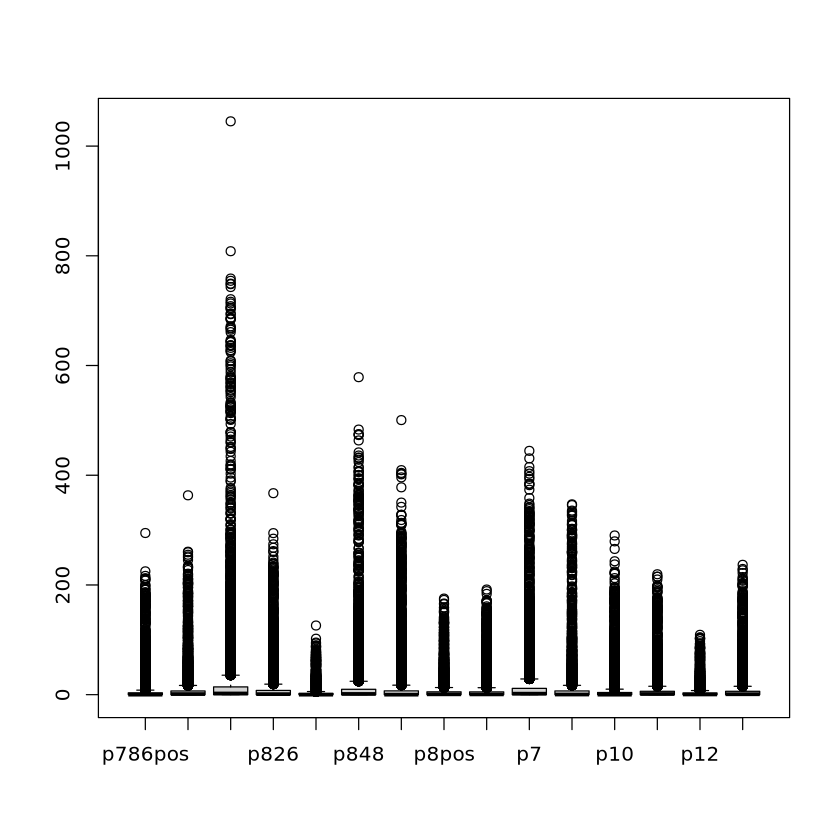

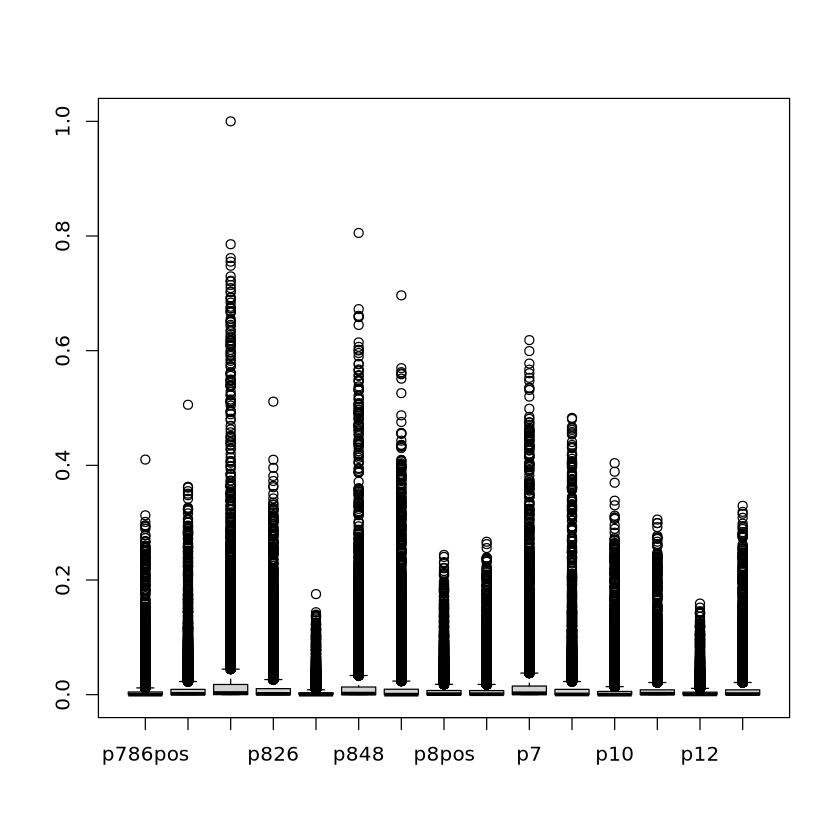

In [26]:
# vor Scaling
boxplot(trans_data)

# Limit threads (verhindert pthread-Fehler auf Clustern)
Sys.setenv(OMP_NUM_THREADS="1", MKL_NUM_THREADS="1",
           OPENBLAS_NUM_THREADS="1", VECLIB_MAXIMUM_THREADS="1")

# Versuche Quantile-Norm, sonst nimm Truncation wie in der Vignette
exp_data <- tryCatch(
  normalize_data(trans_data, by_quantiles = TRUE),
  error = function(e) {
    message("Quantile normalization failed (preprocessCore). Using truncation_percentil = 0.95.")
    normalize_data(trans_data, truncation_percentil = 0.95)
  }
)

boxplot(exp_data)


In [27]:
#4.1
if (length(pathways_list) == 0) {
    message("No pathway list provided -> loading ALL pathways for ", species)
    pathways <- load_pathways(species = species)
} else {
    message("Loading subset of pathways: ", paste(pathways_list, collapse = ", "))
    pathways <- load_pathways(species = species, pathways_list = pathways_list)
}

# ---- Check
length(pathways)   # Anzahl geladener Pathways
names(pathways)[1:5]  # Erste 5 Pathways anzeigen
get_pathways_list(pathways)[1:10]

No pathway list provided -> loading ALL pathways for hsa

Loaded 146 pathways



[1] 7

[1] "species"     "all.genes"   "path.norm"   "eff.norm"    "pathigraphs"

[1] "hsa03320" "hsa03460" "hsa04010" "hsa04012" "hsa04014" "hsa04015"
 [7] "hsa04020" "hsa04022" "hsa04024" "hsa04062"

In [28]:
#4.3 Using Hipathia to comute the signal
results <- hipathia(exp_data, pathways, decompose = FALSE, verbose=FALSE)
## Added missing genes: 165 (4.93%)

Added missing genes: 55 (0.25%)



In [29]:
#4.3 Using Hipathia to comute the signal
results

A MultiAssayExperiment object of 2 listed
 experiments with user-defined names and respective classes.
 Containing an ExperimentList class object of length 2:
 [1] nodes: SummarizedExperiment with 6826 rows and 15 columns
 [2] paths: SummarizedExperiment with 1876 rows and 15 columns
Functionality:
 experiments() - obtain the ExperimentList instance
 colData() - the primary/phenotype DataFrame
 sampleMap() - the sample coordination DataFrame
 `$`, `[`, `[[` - extract colData columns, subset, or experiment
 *Format() - convert into a long or wide DataFrame
 assays() - convert ExperimentList to a SimpleList of matrices
 exportClass() - save data to flat files

In [30]:
#4.3 Using Hipathia to comute the signal
path_vals <- get_paths_data(results)
hhead(path_vals, 4)

,p786pos,p786neg,p811,p826
P-hsa03320-37,0,0.000000e+00,0,0
P-hsa03320-61,0,7.350786e-06,0,0
P-hsa03320-46,0,0.000000e+00,0,0
P-hsa03320-57,0,0.000000e+00,0,0


#5 Function activation computation
uniprot_vals <- quantify_terms(results, pathways, dbannot = "uniprot")

go_vals <- quantify_terms(results, pathways, dbannot = "GO")
#142/1654 soll so sein

In [31]:
#6.1  Two classes comparison
design <- read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE)
design <- design[!duplicated(design$orig.ident), c("orig.ident","group")]
rownames(design) <- design$orig.ident

sample_group <- design[colnames(path_vals), "group"]
comp <- do_wilcoxon(path_vals[, names(sample_group), drop = FALSE], sample_group, g1 = "Tumor", g2 = "Normal")
head(comp)


,UP/DOWN,statistic,p.value,FDRp.value
,<chr>,<dbl>,<dbl>,<dbl>
P-hsa03320-37,DOWN,-3.061862,1,1
P-hsa03320-61,DOWN,-3.061862,1,1
P-hsa03320-46,DOWN,-3.061862,1,1
P-hsa03320-57,DOWN,-3.061862,1,1
P-hsa03320-64,DOWN,-3.061862,1,1
P-hsa03320-47,DOWN,-3.061862,1,1


In [32]:
#6.1  Two classes comparison
pathways_summary <- get_pathways_summary(comp, pathways)
head(pathways_summary, 4)

,id_pathways,num_total_paths,num_significant_paths,percent_significant_paths,num_up_paths,percent_up_paths,num_down_paths,percent_down_paths
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
PPAR signaling pathway,hsa03320,42,0,0,0,0,0,0
Fanconi anemia pathway,hsa03460,7,0,0,0,0,0,0
MAPK signaling pathway,hsa04010,28,0,0,0,0,0,0
ErbB signaling pathway,hsa04012,18,0,0,0,0,0,0


In [33]:
#6.2 Pricipal Components ANalysis
ranked_path_vals <- path_vals[order(comp$p.value, decreasing = FALSE),]
pca_model <- do_pca(ranked_path_vals[1:ncol(ranked_path_vals),])

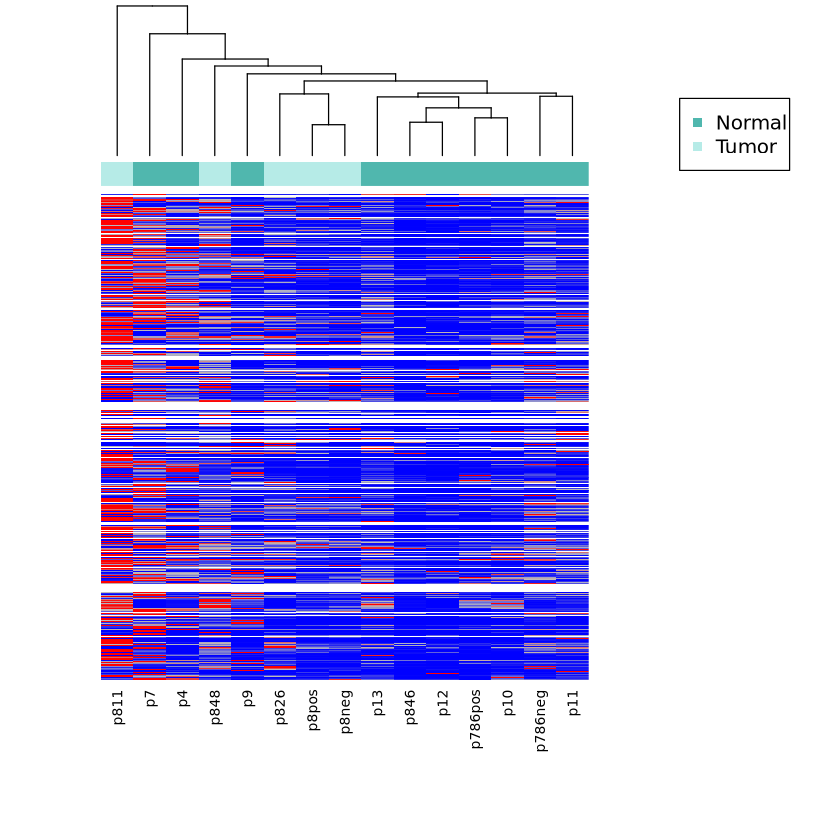

In [34]:
#7Heatmap
heatmap_plot(path_vals, group = sample_group)


In [35]:
# This should be TRUE; if FALSE, you sorted columns/rows inkonsistent
all(rownames(ranked_path_vals) %in% rownames(path_vals))
all(rownames(ranked_path_vals)[1:5] == rownames(comp)[order(comp$p.value, decreasing=FALSE, na.last=NA)][1:5])


[1] TRUE

[1] TRUE

In [36]:
heatmap_plot(uniprot_vals, group = sample_group, colors="hipathia",
variable_clust = TRUE)
heatmap_plot(go_vals, group = sample_group, colors="redgreen",
variable_clust = TRUE)

ERROR: Error: object 'uniprot_vals' not found


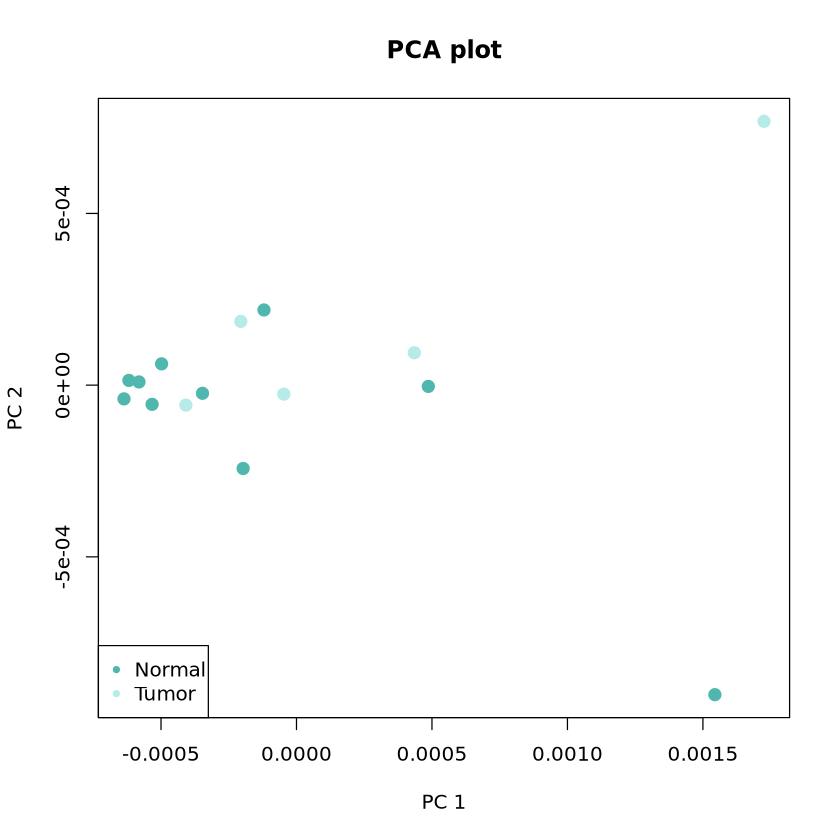

In [37]:
pca_plot(pca_model, sample_group, legend = TRUE)

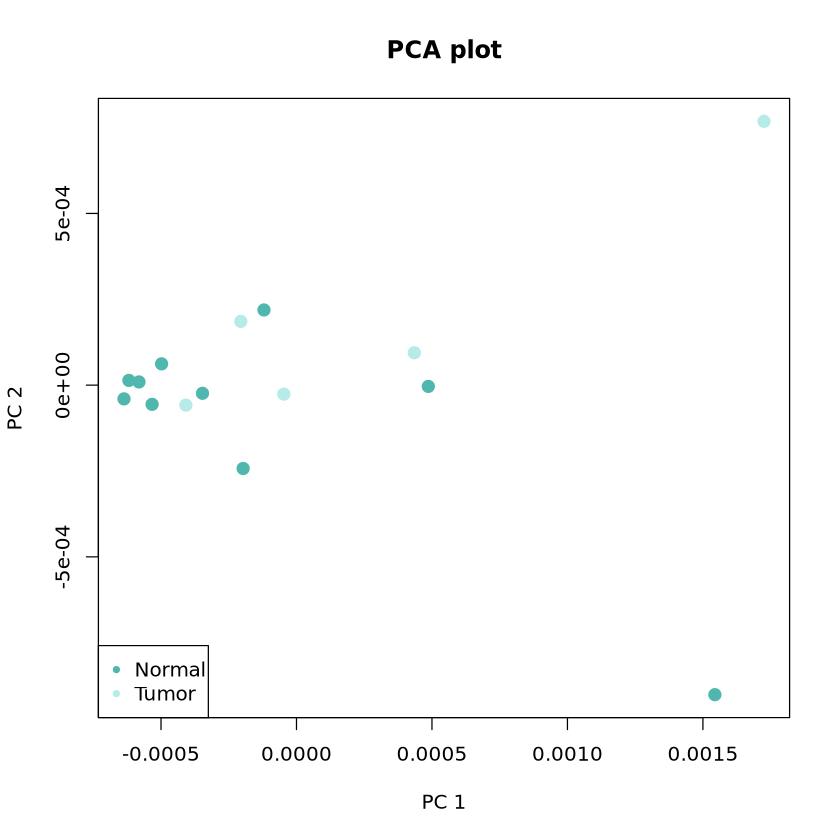

In [38]:
pca_plot(pca_model, sample_group, legend = TRUE)

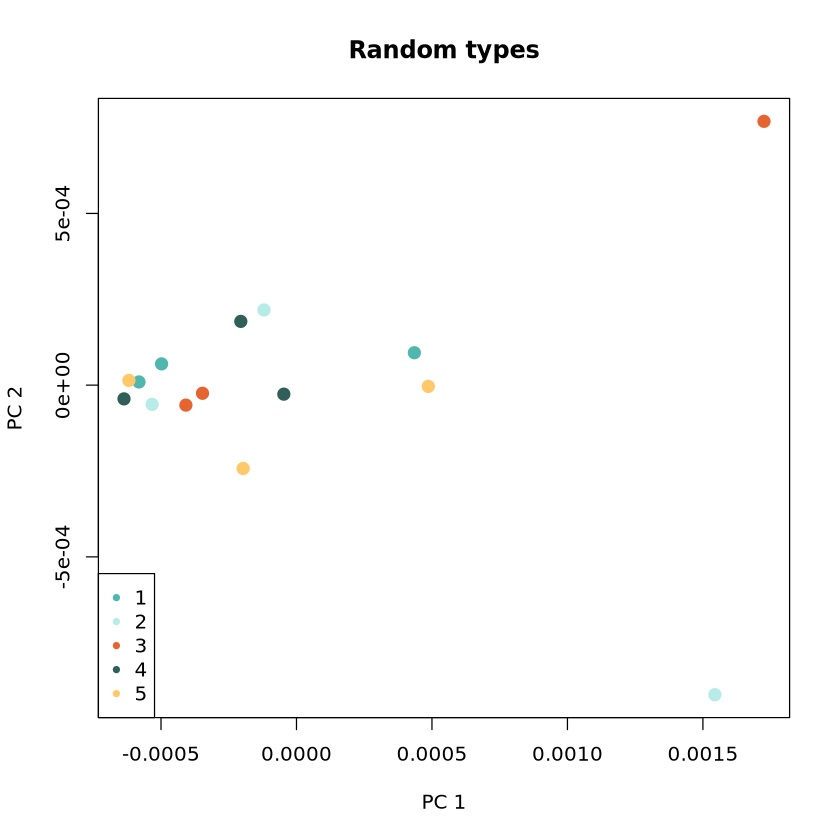

In [39]:

pca_plot(pca_model, group = rep(1:5, 8), main = "Random types",
legend = TRUE)

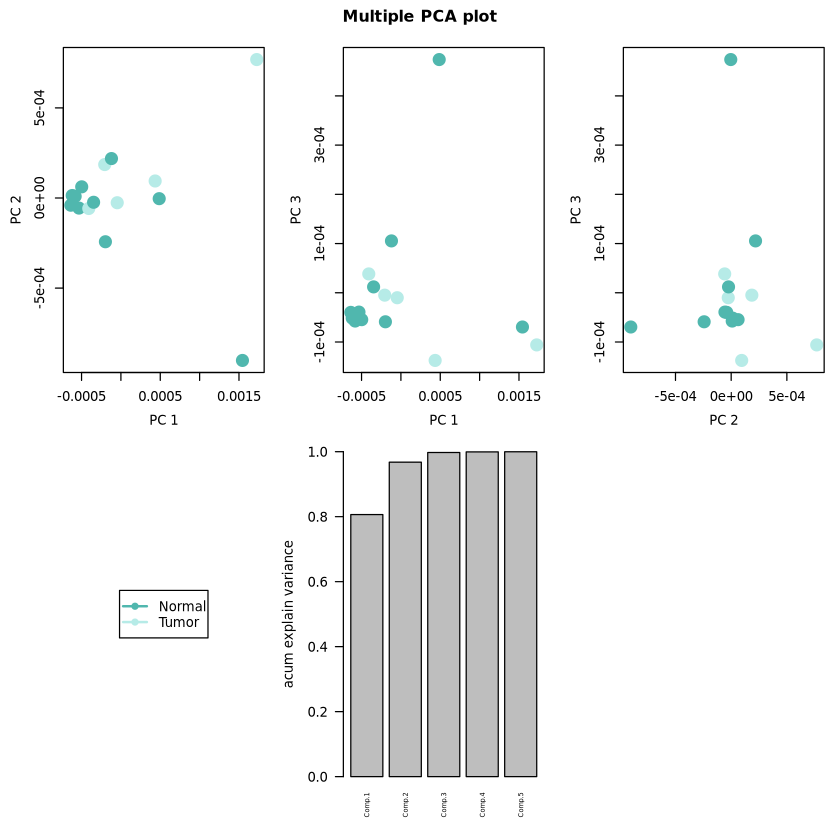

In [40]:
multiple_pca_plot(pca_model, sample_group, cex=3, plot_variance = TRUE)

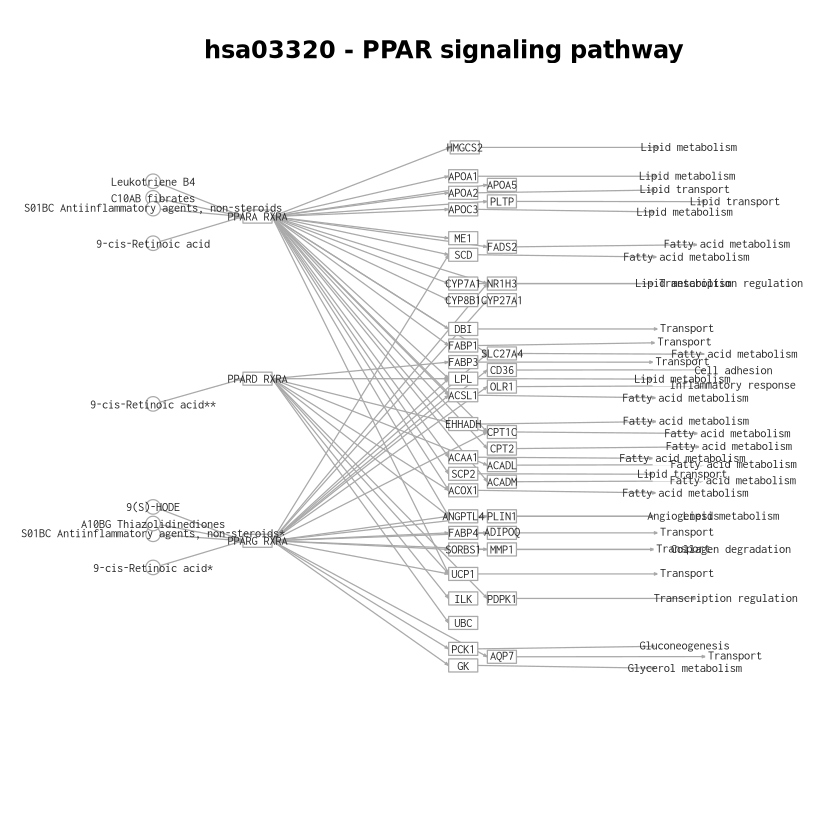

In [41]:
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320")

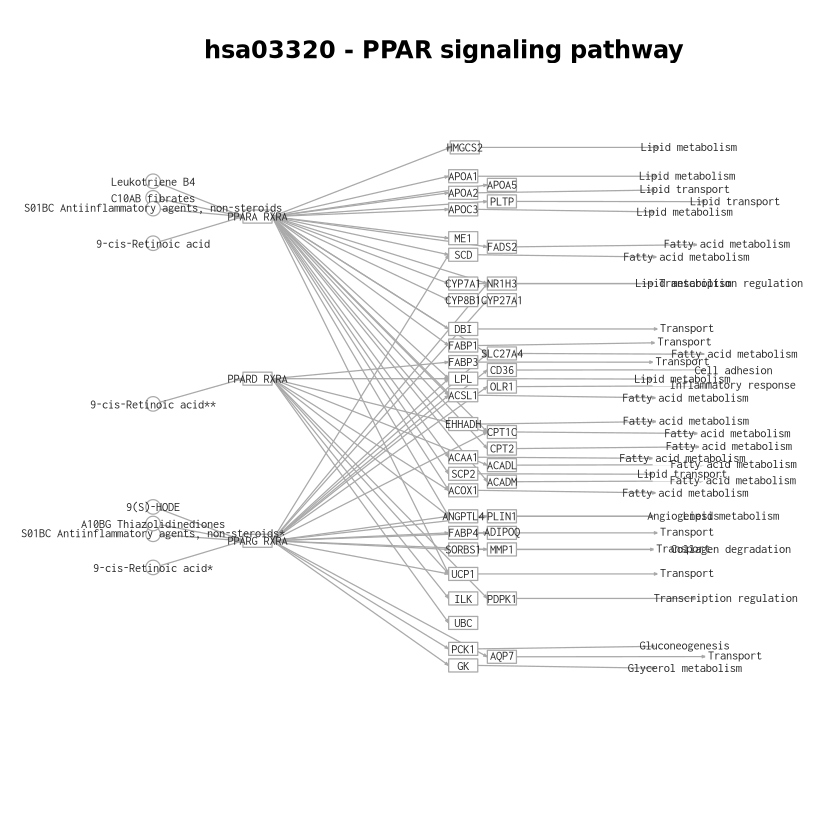

In [42]:
colors_de <- node_color_per_de(results, pathways, sample_group, "Tumor",
"Normal")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de)

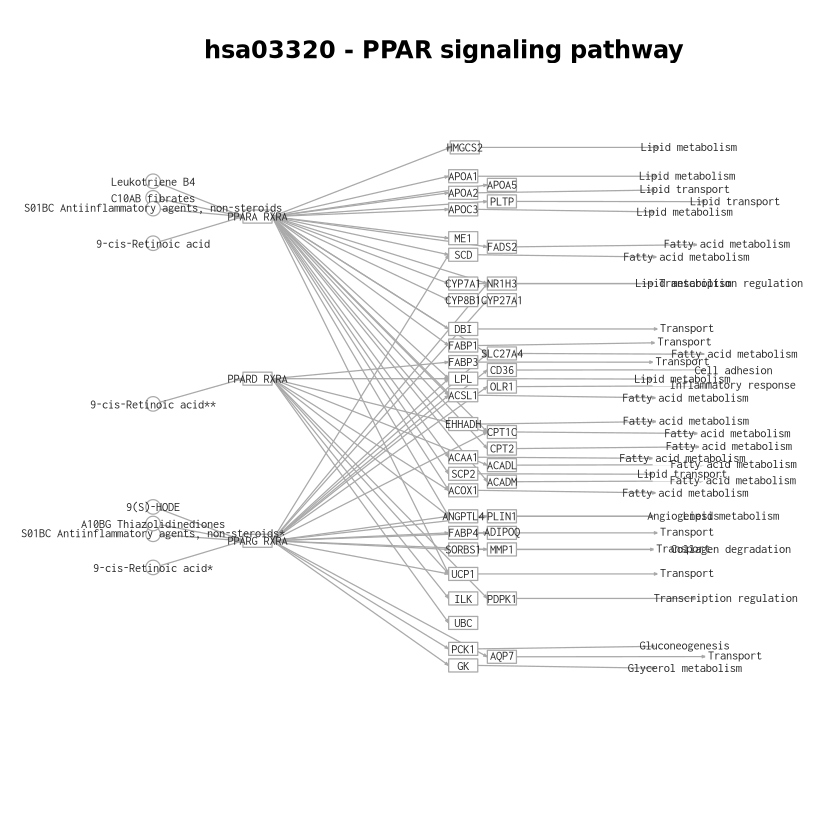

In [43]:
colors_de_hipathia <- node_color_per_de(results, pathways, sample_group,
"Tumor", "Normal", colors = "hipathia")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de_hipathia, colors = "hipathia")
pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = colors_de_hipathia,
  colors = "hipathia",
)

In [44]:
#7.4. Vizualization through a local server
report <- create_report(comp, pathways, "save_noColors")
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...
#report_colors <- create_report(comp, pathways, "save_colors",
#node_colors = colors_de)
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...


Creating report folders...

Creating pathways folder...

Creating HTML index...



In [ ]:

visualize_report(report, port = 4002)

In [ ]:
# 1) alte servr-Prozesse beenden
if (requireNamespace("servr", quietly = TRUE)) {
  dl <- try(servr::daemon_list(), silent = TRUE)
  if (!inherits(dl, "try-error") && NROW(dl)) {
    for (i in dl$id) try(servr::daemon_stop(i), silent = TRUE)
  }
}

# 2) freien Port wählen
port <- servr::random_port()  # nimmt garantiert freien Port, z.B. 4010

# 3) Report visualisieren
visualize_report(report, port = port)


In [ ]:
apply(trans_data, 2, sd)


In [ ]:
comp$FDRp.value <- runif(nrow(comp), 0, 0.01)  # zufällige kleine Werte
comp$UP.DOWN <- sample(c("UP","DOWN"), nrow(comp), replace = TRUE)

pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = node_color_per_de(results, pathways, sample_group,
                                  "Tumor", "Normal", colors = "hipathia"),
  colors = "hipathia"
)


In [ ]:
apply(trans_data, 2, sd)


In [ ]:
table(design$group)


In [ ]:
table(meta$group, meta$orig.ident)
